In [28]:
# data wrangling
import pandas as pd
import numpy as np
from datetime import datetime, date, timedelta

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# offline interactive visualization
from plotly.offline import plot, iplot, init_notebook_mode
init_notebook_mode(connected=True)

# regression
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.graphics.api as smg

import warnings
warnings.filterwarnings("ignore")

In [29]:
worldometer_data = pd.read_csv('worldometer_data.csv')

In [30]:
worldometer_data.head()

,Country/Region,Continent,Population,TotalCases,NewCases,TotalDeaths,NewDeaths,TotalRecovered,NewRecovered,ActiveCases,"Serious,Critical",Tot Cases/1M pop,Deaths/1M pop,TotalTests,Tests/1M pop,WHO Region
0,USA,North America,3.311981e+08,5032179,NaN,162804.0,NaN,2576668.0,NaN,2292707.0,18296.0,15194.0,492.0,63139605.0,190640.0,Americas
1,Brazil,South America,2.127107e+08,2917562,NaN,98644.0,NaN,2047660.0,NaN,771258.0,8318.0,13716.0,464.0,13206188.0,62085.0,Americas
2,India,Asia,1.381345e+09,2025409,NaN,41638.0,NaN,1377384.0,NaN,606387.0,8944.0,1466.0,30.0,22149351.0,16035.0,South-EastAsia
3,Russia,Europe,1.459409e+08,871894,NaN,14606.0,NaN,676357.0,NaN,180931.0,2300.0,5974.0,100.0,29716907.0,203623.0,Europe
4,South Africa,Africa,5.938157e+07,538184,NaN,9604.0,NaN,387316.0,NaN,141264.0,539.0,9063.0,162.0,3149807.0,53044.0,Africa


In [31]:
worldometer_data = worldometer_data.replace('', np.nan).fillna(0)

In [32]:
worldometer_data['Country/Region'].replace({'USA':'US', 'UAE':'United Arab Emirates', 'S. Korea':'South Korea', \
                                           'UK':'United Kingdom'}, inplace=True)

In [33]:
full_grouped = pd.read_csv('full_grouped.csv')

In [34]:
full_grouped

,Date,Country/Region,Confirmed,Deaths,Recovered,Active,New cases,New deaths,New recovered,WHO Region
0,2020-01-22,Afghanistan,0,0,0,0,0,0,0,Eastern Mediterranean
1,2020-01-22,Albania,0,0,0,0,0,0,0,Europe
2,2020-01-22,Algeria,0,0,0,0,0,0,0,Africa
3,2020-01-22,Andorra,0,0,0,0,0,0,0,Europe
4,2020-01-22,Angola,0,0,0,0,0,0,0,Africa
...,...,...,...,...,...,...,...,...,...,...
35151,2020-07-27,West Bank and Gaza,10621,78,3752,6791,152,2,0,Eastern Mediterranean
35152,2020-07-27,Western Sahara,10,1,8,1,0,0,0,Africa
35153,2020-07-27,Yemen,1691,483,833,375,10,4,36,Eastern Mediterranean
35154,2020-07-27,Zambia,4552,140,2815,1597,71,1,465,Africa


In [35]:
full_grouped = full_grouped.merge(worldometer_data[['Country/Region', 'Population']], how='left', on='Country/Region')

In [36]:
full_grouped

,Date,Country/Region,Confirmed,Deaths,Recovered,Active,New cases,New deaths,New recovered,WHO Region,Population
0,2020-01-22,Afghanistan,0,0,0,0,0,0,0,Eastern Mediterranean,39009447.0
1,2020-01-22,Albania,0,0,0,0,0,0,0,Europe,2877470.0
2,2020-01-22,Algeria,0,0,0,0,0,0,0,Africa,43926079.0
3,2020-01-22,Andorra,0,0,0,0,0,0,0,Europe,77278.0
4,2020-01-22,Angola,0,0,0,0,0,0,0,Africa,32956300.0
...,...,...,...,...,...,...,...,...,...,...,...
35151,2020-07-27,West Bank and Gaza,10621,78,3752,6791,152,2,0,Eastern Mediterranean,NaN
35152,2020-07-27,Western Sahara,10,1,8,1,0,0,0,Africa,598682.0
35153,2020-07-27,Yemen,1691,483,833,375,10,4,36,Eastern Mediterranean,29886897.0
35154,2020-07-27,Zambia,4552,140,2815,1597,71,1,465,Africa,18430129.0


In [37]:
full_grouped['Date'] = pd.to_datetime(full_grouped['Date'], format = '%Y-%m-%d')

In [38]:
full_grouped['Date']

0       2020-01-22
1       2020-01-22
2       2020-01-22
3       2020-01-22
4       2020-01-22
           ...    
35151   2020-07-27
35152   2020-07-27
35153   2020-07-27
35154   2020-07-27
35155   2020-07-27
Name: Date, Length: 35156, dtype: datetime64[ns]

In [39]:
def sir_model(I0=0.01, beta=0.6, gamma=0.1, days=365, date=date.today()):
    """
    Function will take in initial state for infected population,
    Transmission rate (beta) and recovery rate(gamma) as input.

    The function returns the maximum percentage of infectious population,
    the number of days to reach the maximum (inflection point),
    the maximum percentage of population infected,
    the number of days to reach 80% of the maximum percentage of population infected.

    """
    ## Initialize model parameters
    N = 1          #Total population in percentage, i.e., 1 = 100%
    I = I0         #Initial state of I default value 1% of population, i.e., I0 = 0.01
    S = N - I      #Initial state of S
    R = 0          #Initial State of R
    C = I          #Initial State of Total Cases
    beta  = beta   #Transmission Rate
    gamma = gamma  #Recovery Rate

    ## Initialize empty lists
    inf  = []       # List of Infectious population for each day
    day  = []       # Time period in day
    suc  = []       # List of Susceptible population for each day
    rec  = []       # List of Recovered population for each day
    conf = []       # List of Total Cases population for each day

    ## Project into the future
    for i in range(days):
        day.append(i)
        inf.append(I)
        suc.append(S)
        rec.append(R)
        conf.append(C)

        new_inf= I*S*beta/N            #New infections equation (1)
        new_rec= I*gamma               #New Recoveries equation (2)

        I=I+new_inf-new_rec            #Total infectious population for next day
        S=max(min(S - new_inf, N), 0)  #Total infectious population for next day
        R=min(R + new_rec, N)          #Total recovered population for next day

        C=C+new_inf                    #Total confirmed cases for next day

    ## Pinpoint important milestones
    max_inf = round(np.array(inf).max()*100,2)        #Peak infectious population in percentage
    inflection_day = inf.index(np.array(inf).max())   #Peak infectious population in days
    max_conf = round(np.array(conf).max()*100,2)      #Overall infected population in percentage
    plateau_day = np.array(np.where(np.array(conf) >= 0.8*np.array(conf).max())).min()   #Peak infectious population in days

    print(f"Maximum Infectious population at a time :{max_inf}%")
    print(f"Number of Days to Reach Maximum Infectious Population (Inflection Point):{inflection_day} days or {date + timedelta(days=inflection_day)}")
    print(f"Total Infected population :{max_conf}%")
    print(f"Number of Days to Reach 80% of the Projected Confirmed Cases (Plateau Point):{plateau_day} days or {date + timedelta(days=plateau_day.item())}")

    ## Visualize the model outputs
    sns.set(style="darkgrid")
    plt.figure(figsize=(10,6))
    plt.title(f"SIR Model: R = {round(beta/gamma,2)}", fontsize=18)
    sns.lineplot(x=day, y=inf, label="Infectious")
    sns.lineplot(x=day, y=suc, label="Susceptible")
    sns.lineplot(x=day, y=rec, label="Recovered")

    plt.legend()
    plt.xlabel("Time (in days)")
    plt.ylabel("Fraction of Population")
    plt.show()

Maximum Infectious population at a time :23.9%
Number of Days to Reach Maximum Infectious Population (Inflection Point):166 days or 2025-10-24
Total Infected population :88.42%
Number of Days to Reach 80% of the Projected Confirmed Cases (Plateau Point):193 days or 2025-11-20


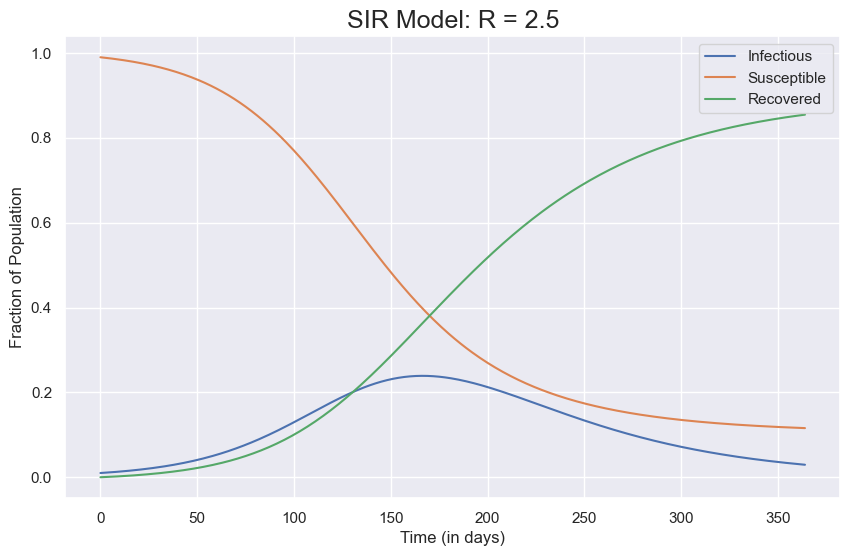

In [40]:
sir_model(beta=0.05, gamma=0.02, days=365)

In [41]:
def sir_model_betalist(I0 = 0.01, betalist = [0.5,0.8], gammalist = [0.15,0.25,0.5], days = 365):
    """
    Function takes Initial Infected Population(I0), list of transmission rates (betalist)
    and list of recovery rates(gammalist) as arguments.
    Plots Infectious population and Infected Population vs time for input parameters
    """

    for gamma in gammalist:

        # A. Plot Infectious Population
        plt.figure(figsize=(10,6))
        sns.set(style="darkgrid")
        plt.title("SIR Model: Infectious Population", fontsize=18)

        # Initialize model parameters
        for beta in betalist:
            N=1
            I=I0
            S=N-I
            gamma=gamma
            R=beta/gamma

            # Initialize empty lists
            inf=[]
            day=[]

            # Project into the future
            for i in range(days):
                day.append(i)
                inf.append(I)
                new_inf= I*S*beta
                new_rec= I*gamma
                I=I+new_inf-new_rec
                S=S-new_inf

            # Create plot objects by gamma and beta
            inf_max=round(np.array(inf).max()*100,1)
            sns.lineplot(x=day, y=inf, label=f"Beta: {beta} Gamma: {gamma} R0: {round(R,2)} Peak: {inf_max}%")

            plt.legend()

        # Show all plots objects
        plt.show()

        # B. Plot Total Infected Population
        plt.figure(figsize=(10,6))
        plt.title("SIR Model: Total Confirmed Cases", fontsize=18)

        # Initialize model parameters
        for beta in betalist:
            N=1
            I=I0
            S=N-I
            C=I
            gamma=gamma
            R=beta/gamma

            # Initialize empty lists
            day=[]
            conf=[]

            # Project into the future
            for i in range(days):
                day.append(i)
                conf.append(C)

                new_inf= I*S*beta
                new_rec= I*gamma
                I=I+new_inf-new_rec
                S=S-new_inf
                C=C+new_inf

            # Create plot objects by gamma and beta
            conf_max=round(np.array(conf).max()*100,1)
            sns.lineplot(x=day, y=conf, label=f"Beta: {beta} Gamma: {gamma} R0: {round(R,2)} Total :{conf_max}%")

            plt.legend()

        # Show all plots objects
        plt.show()

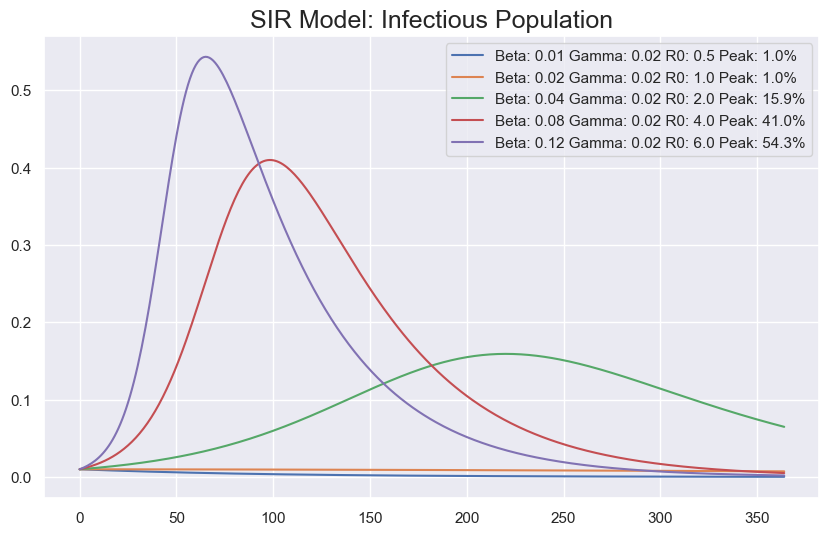

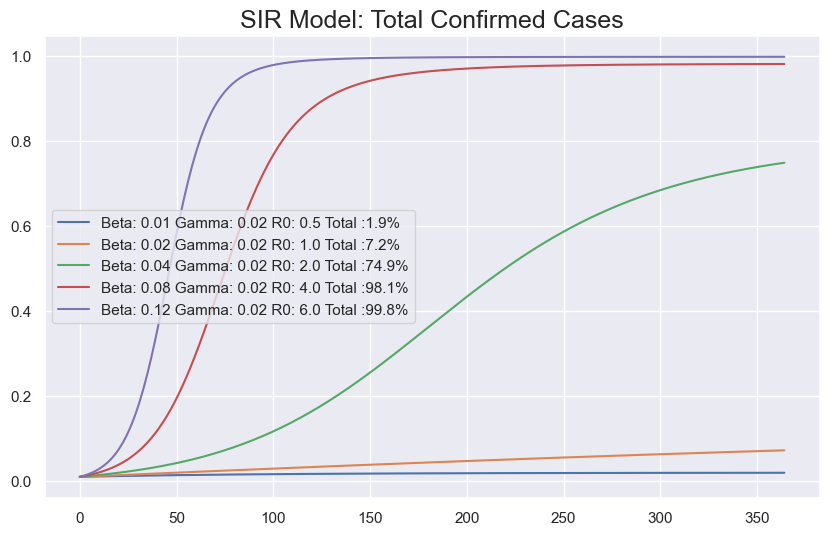

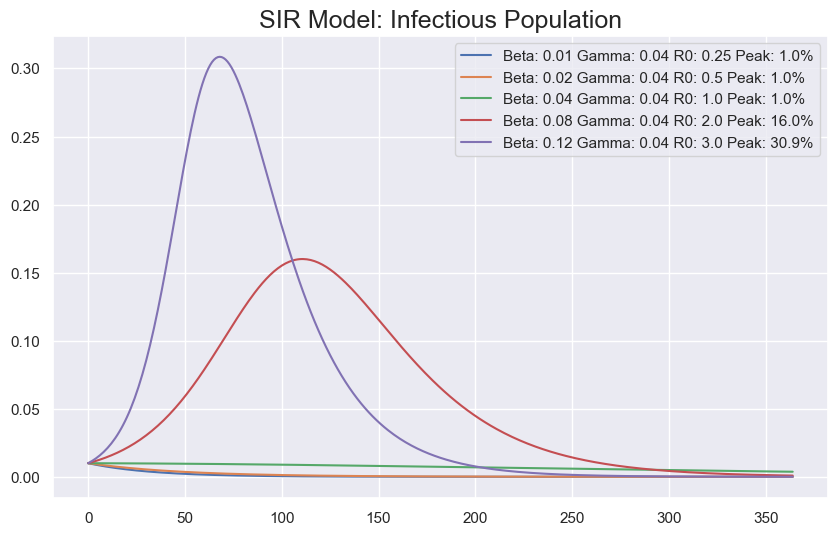

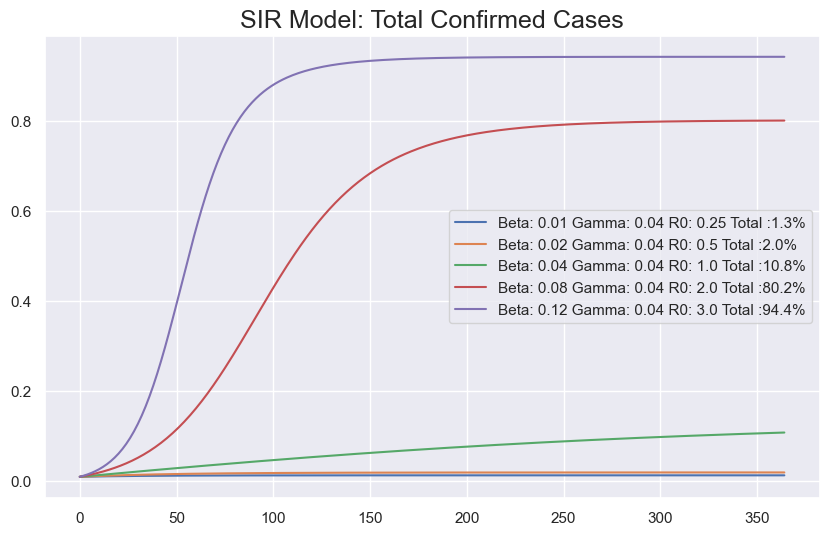

In [42]:
sir_model_betalist(I0=0.01,betalist=[0.01, 0.02, 0.04, 0.08, 0.12], gammalist=[0.02, 0.04])

In [43]:
 def plot_country(country, date):
    temp = full_grouped[full_grouped['Country/Region']==country]
    temp['recent_wave'] = np.where(temp['Date'] >= date,1,0)

    fig = px.line(temp, x='Date', y='Confirmed', color='recent_wave', \
                  title = 'Infections for ' + str(country), height=600)
    fig.show()

    fig = px.line(temp, x='Date', y='Recovered', color='recent_wave', \
              title = 'Recovered Patients ' + str(country), height=600)
    fig.show()

    return country, date

In [44]:
pip install --upgrade nbformat


[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [45]:
country, date = plot_country('India', '2020-07-04')

In [46]:

def estimate_sir_param(country, date):


    population  = full_grouped[full_grouped['Country/Region']==country]["Population"].max()
    latest_date = full_grouped[full_grouped['Country/Region']==country]["Date"].max().to_datetime64()

    date = np.datetime64(date)

    time_series_length = (latest_date - np.datetime64(datetime.strptime(str(date),'%Y-%m-%d'))).astype('timedelta64[D]').astype(int) + 1

    temp = full_grouped[full_grouped['Country/Region']==country]
    temp['recent_wave'] = np.where(temp['Date'] >= date,1,0)

    N  = np.array([population] * time_series_length)
    S  = np.array([])
    dt = np.array([1] * (time_series_length-1))

    # Applying the condition N = S+I+(R+D)
    I = np.array(temp[temp['recent_wave']==1]['Active'])
    R = np.array(temp[temp['recent_wave']==1]['Recovered'])
    D = np.array(temp[temp['recent_wave']==1]['Deaths'])


    S = N - I - (R + D)

    # Estimating beta

    x = (S * I) / N


    x = x[:-1].copy()


    dS = np.diff(S)
    y = dS/dt

    # Fit into a linear regression
    results = sm.OLS(y, x, missing='drop').fit()
    beta = results.params
    print(results.summary())
    print('\n')
    print('*'*80)
    print(f"Transmission rate or Beta is: {beta}")
    print('*'*80)

    # Estimating gamma

    x = I[:-1].copy()
    dR = np.diff(R+D)
    y = dR/dt

    results = sm.OLS(endog=y, exog=x, missing='drop').fit()
    gamma = results.params
    print (results.summary())
    print('\n')
    print('*'*80)
    print(f"Recovery (and Mortality) rate or Gamma is: {gamma}")
    print('*'*80)

    # Calculating R

    print('\n')
    print('*'*80)
    print(f"Reproduction number or R is: {-beta/gamma}")
    print('*'*80)

    return -beta.astype('float'), gamma.astype('float'), datetime.strptime(str(date), '%Y-%m-%d').date()


In [47]:
beta, gamma, date = estimate_sir_param(country, date)

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.994
Model:                            OLS   Adj. R-squared (uncentered):              0.994
Method:                 Least Squares   F-statistic:                              3777.
Date:                Sun, 11 May 2025   Prob (F-statistic):                    4.14e-26
Time:                        19:39:33   Log-Likelihood:                         -214.84
No. Observations:                  23   AIC:                                      431.7
Df Residuals:                      22   BIC:                                      432.8
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

Maximum Infectious population at a time :9.78%
Number of Days to Reach Maximum Infectious Population (Inflection Point):37 days or 2020-08-10
Total Infected population :61.74%
Number of Days to Reach 80% of the Projected Confirmed Cases (Plateau Point):71 days or 2020-09-13


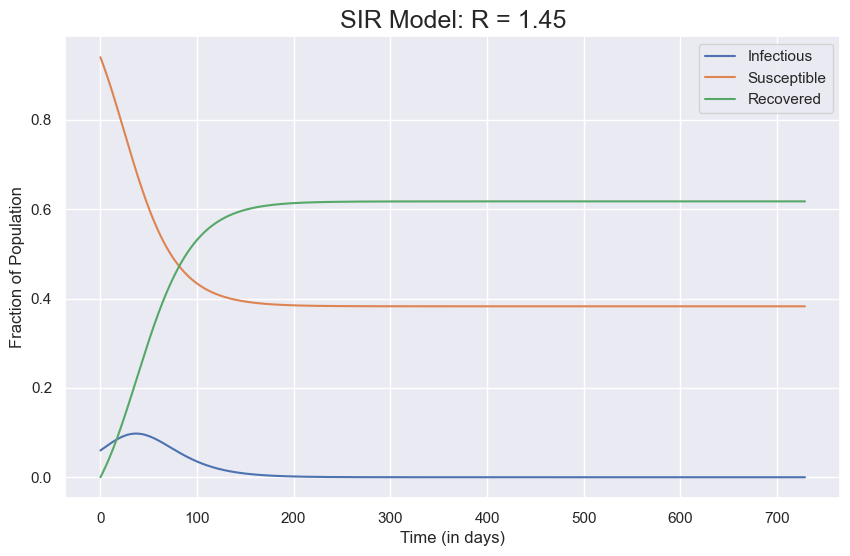

In [48]:
sir_model(I0=0.06, beta = beta.item(), gamma = gamma.item(), days=730, date = date)

In [49]:
country1, date = plot_country('US', '2020-07-04')

In [50]:
beta, gamma, date = estimate_sir_param(country1, date)

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.981
Model:                            OLS   Adj. R-squared (uncentered):              0.981
Method:                 Least Squares   F-statistic:                              1165.
Date:                Sun, 11 May 2025   Prob (F-statistic):                    1.50e-20
Time:                        19:39:34   Log-Likelihood:                         -241.09
No. Observations:                  23   AIC:                                      484.2
Df Residuals:                      22   BIC:                                      485.3
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

Maximum Infectious population at a time :34.48%
Number of Days to Reach Maximum Infectious Population (Inflection Point):186 days or 2021-01-06
Total Infected population :95.44%
Number of Days to Reach 80% of the Projected Confirmed Cases (Plateau Point):216 days or 2021-02-05


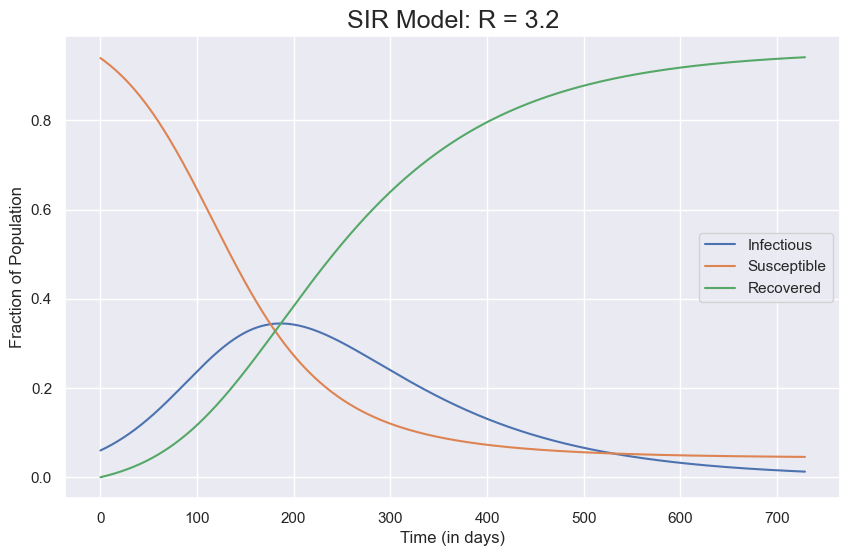

In [51]:
sir_model(I0=0.06, beta = beta.item(), gamma = gamma.item(), days=730, date = date)

In [52]:
country2, date = plot_country('Brazil', '2020-07-04')

In [53]:
beta, gamma, date = estimate_sir_param(country2, date)

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.891
Model:                            OLS   Adj. R-squared (uncentered):              0.886
Method:                 Least Squares   F-statistic:                              179.0
Date:                Sun, 11 May 2025   Prob (F-statistic):                    4.80e-12
Time:                        19:39:35   Log-Likelihood:                         -250.87
No. Observations:                  23   AIC:                                      503.7
Df Residuals:                      22   BIC:                                      504.9
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

Maximum Infectious population at a time :6.0%
Number of Days to Reach Maximum Infectious Population (Inflection Point):0 days or 2020-07-04
Total Infected population :30.38%
Number of Days to Reach 80% of the Projected Confirmed Cases (Plateau Point):71 days or 2020-09-13


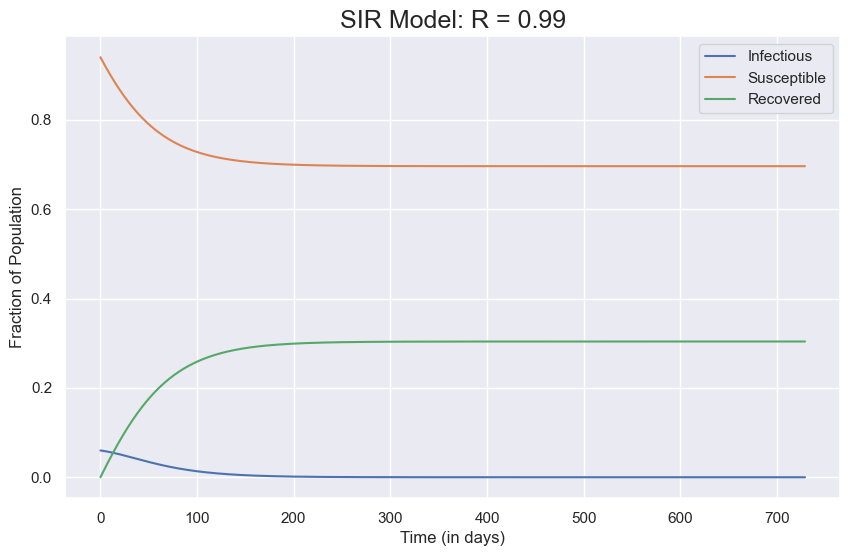

In [54]:
sir_model(I0=0.06, beta = beta.item(), gamma = gamma.item(), days=730, date = date)